#### We will be exploring the gan. What it is ?

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init

In [41]:
class Generator(nn.Module): # Inheriting from nn.Module in PyTorch enables parameter tracking, automatic differentiation for training, and GPU/CPU compatibility. It also allows you to nest modules and facilitates model serialization for saving/loading.
  def __init__(self):
    super(Generator,self).__init__() # calling parent call constuctor
    self.model = nn.Sequential(
        nn.Linear(100,256),
        nn.LeakyReLU(),
        nn.Linear(256,256*2),
        nn.LeakyReLU(),
        nn.Linear(256*2,256*4),
        nn.LeakyReLU(),
        nn.Linear(256*4,784),
        nn.Tanh()
    )

  def forward(self,x):
    x = self.model(x)
    return x

# Generator()

In [42]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.model = nn.Sequential(
        nn.Linear(784,1024),
        nn.LeakyReLU(),

        nn.Linear(1024,1024//2),
        nn.LeakyReLU(),

        nn.Linear(1024//2,1024//4),
        nn.LeakyReLU(),

        nn.Linear(1024//4,1),
        nn.Sigmoid()
    )


  def forward(self,x):
    x = self.model(x)
    return x


# Discriminator()

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [58]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

The code defines a function called initialize_weights for Xavier (Glorot) weight initialization in neural network layers. Xavier initialization is vital in deep learning to stabilize training. The function takes a neural network model as input and iterates through its modules, checking if each module is a convolutional or linear layer using isinstance.

If a module is a convolutional or linear layer, Xavier initialization is applied to its weights using init.xavier_normal_(). This initialization method helps prevent issues like vanishing or exploding gradients during training. The code also sets bias values to zero if they exist. Overall, initialize_weights is a valuable tool for setting up a neural network's initial weights for successful training.

In [59]:
def initialize_weights(model):
  for m in model.modules():
    if isinstance(m,(nn.Conv2d,nn.Linear)):
      init.xavier_normal_(m.weight)
      if m.bias is not None:
        m.bias.data.fill_(0.0)


In [60]:
initialize_weights(generator)
initialize_weights(discriminator)

In [61]:
criterion = nn.BCELoss() # binary cross entropy loss

optimizer_g = optim.Adam( generator.parameters(), lr=0.0002 )
optimizer_d = optim.Adam( discriminator.parameters(), lr = 0.0002 )



In [62]:
# loading dataset

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))


                                ])
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           download=True,
                                           transform=transform # It will run for each example
                                           )


train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
# This is will do batch and speed up the loading time of data.




#### Both real_images.reshape(-1, 784) and real_images.view(-1, 784) reshape tensors into (batch_size, 784), but view performs stricter shape validation.

#### real_images.reshape(-1, 784) or real_images.reshape(64, 28,28) or real_images.reshape(64, 28,28,1) or real_images.reshape(64, 28,28,1,1,1,1...) is possible as long as they multiples does exceed 784

In [63]:
num_epochs = 100


for epoch in range(num_epochs):
  for batch_idx ,(real_images,labels) in enumerate(train_loader):
    #  Training the discriminator
    real_images=real_images.to(device)
    real_labels = torch.ones(real_images.size(0) , 1)
    fake_labels = torch.zeros(real_images.size(0) , 1)
    real_outputs = discriminator( real_images.view(-1,784) )
    d_loss_real = criterion(real_outputs,real_labels.to(device))

    noise = torch.randn(real_images.size(0),100 )
    fake_images = generator(noise.to(device))
    fake_outputs = discriminator(fake_images.detach())
    d_loss_fake = criterion(fake_outputs,fake_labels.to(device))

    d_loss = (d_loss_real + d_loss_fake)
    optimizer_d.zero_grad()
    d_loss.backward()
    optimizer_d.step()

    #  Training the generator
    noise = torch.randn(real_images.size(0),100)
    fake_images = generator(noise.to(device))
    fake_outputs = discriminator(fake_images)
    g_loss = criterion(fake_outputs,real_labels.to(device))
    optimizer_g.zero_grad()
    g_loss.backward()
    optimizer_g.step()

    if (batch_idx + 1) % 100 == 0:
      print(f'Epoch [{epoch + 1}/{num_epochs}] Batch [{batch_idx + 1}/{len(train_loader)}] '
            f'D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}')




Epoch [1/100] Batch [100/938] D_loss: 0.1839 G_loss: 2.5953
Epoch [1/100] Batch [200/938] D_loss: 1.0470 G_loss: 8.6510
Epoch [1/100] Batch [300/938] D_loss: 0.1103 G_loss: 9.8302
Epoch [1/100] Batch [400/938] D_loss: 0.0385 G_loss: 5.7511
Epoch [1/100] Batch [500/938] D_loss: 0.0425 G_loss: 5.4803
Epoch [1/100] Batch [600/938] D_loss: 0.0038 G_loss: 6.5202
Epoch [1/100] Batch [700/938] D_loss: 0.0786 G_loss: 9.7570
Epoch [1/100] Batch [800/938] D_loss: 0.0210 G_loss: 7.1719
Epoch [1/100] Batch [900/938] D_loss: 0.0180 G_loss: 9.4528
Epoch [2/100] Batch [100/938] D_loss: 0.0541 G_loss: 18.1346
Epoch [2/100] Batch [200/938] D_loss: 0.4802 G_loss: 16.9265
Epoch [2/100] Batch [300/938] D_loss: 0.3633 G_loss: 6.2958
Epoch [2/100] Batch [400/938] D_loss: 0.2549 G_loss: 5.4001
Epoch [2/100] Batch [500/938] D_loss: 0.3641 G_loss: 6.9151
Epoch [2/100] Batch [600/938] D_loss: 0.4120 G_loss: 6.1457
Epoch [2/100] Batch [700/938] D_loss: 0.1013 G_loss: 5.5301
Epoch [2/100] Batch [800/938] D_loss: 

KeyboardInterrupt: ignored

In [64]:
generator.eval()

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [79]:
num_samples = 10  # Number of images to generate
batch_size = 10  # You can change the batch size if needed
z_dim = 100  # The dimension of the input noise vector (should match your generator's input size)

# Generate random noise vectors
noise = torch.randn(num_samples, z_dim).to(device)

In [80]:
with torch.no_grad():
    fake_images = generator(noise).detach().cpu()

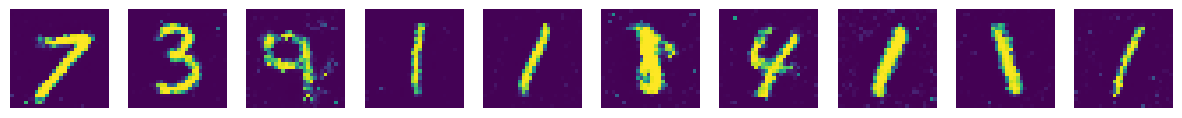

In [83]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_generated_images(images, num_samples):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

    for i in range(num_samples):
        img = images[i]
        transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      ])

        img = transform(img.view(1,28,28))


        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Display the generated images
show_generated_images(fake_images, num_samples)

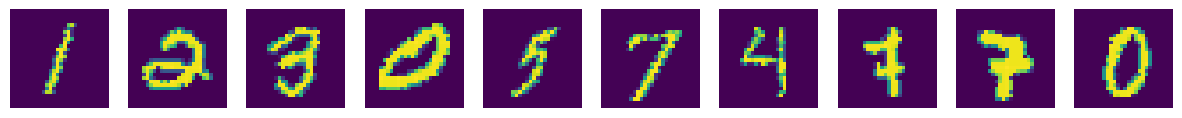

In [82]:
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_generated_images(images, num_samples):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 2))

    for i in range(num_samples):
        img = images[i]
        transform = transforms.Compose([
                                      transforms.ToPILImage(),
                                      ])

        img = transform(img.view(28,28))


        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Display the generated images
show_generated_images(real_images, num_samples)